<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-henry8675309/blob/main/Kapitza_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapitza pendulum plan & objectives

## 1. Equation of Motion Implementation
We solve the dimensionless equation of motion for the pivot-driven pendulum:

$$\theta'' + 2 \zeta \theta' + (\epsilon^2 - \alpha \cos\tau) \sin\theta = 0$$

To implement this for the `scipy.integrate.solve_ivp` solver, we convert it into a system of first-order ODEs where the state vector is $\vec{y} = [\theta, \omega]$:

1.  $\frac{d\theta}{d\tau} = \omega$

2.  $\frac{d\omega}{d\tau} = -2\zeta \omega - (\epsilon^2 - \alpha \cos\tau) \sin\theta$

## 2. Stability Diagnostic Design
To determine if the inverted state is stable, we implement the following diagnostic routine:

**Pseudocode / Algorithm:**
1.  **Initial Conditions:** Start the pendulum at the inverted position with a small perturbation to test if it falls or returns.
    
    * $\theta_0 = \pi - 0.01$
    
    * $\dot{\theta}_0 = 0$
2.  **Integration Span:** Integrate for a duration defined by the damping timescale to ensure transients have decayed.
    
    * $\tau_{end} = \frac{n_{decay}}{2\zeta}$ (where $n_{decay}$ is the number of time constants).

3.  **Transient Removal:** Discard the trajectory data from $\tau=0$ to $\tau_{end} - \Delta \tau$. We only analyze the final window $\Delta \tau$ (set to 1 decay constant).

4.  **Quantification (The Metric):** Calculate the time-average of $\cos(\theta)$ over this final window.
    
    * If **Stable**: The pendulum stays near $\pi$, so $\langle \cos \theta \rangle \approx -1$.
    
    * If **Unstable**: The pendulum falls toward $0$, so $\langle \cos \theta \rangle \approx +1$ (or averages to 0 if rotating).

## 3. Parameter Sweep Strategy
We map the long-time behavior by sweeping over the parameter space:
* **Grid:** We vary $\epsilon$ (frequency ratio) and $\alpha$ (drive amplitude) from $0$ to $1$.
* **Fixed Parameter:** We hold damping constant at $\zeta = 0.1$.
* **Visualization:** We produce a 2D color plot (heatmap) of the stability metric.
* **Boundary Fit:** We overlay a theoretical stability boundary curve of the form $\alpha_c(\epsilon) \approx C \epsilon^2$ to compare with numerical results.

# Analytical Derivation Of The Equation Of Motion (EOM)

---



## Analytical Derivation of EOM

begining with the equation of motion for a damped pendulum with a vertically driven pivot. Analyzing the torques in the non-inertial frame of the pivot (including the fictitious force from the pivot's acceleration $\ddot{y} = -y_0 \omega_d^2 \cos(\omega_d t)$), the dimensional equation is:

$$\ddot{\theta} + 2\gamma \dot{\theta} + \left[ \omega_0^2 - \frac{y_0}{l} \omega_d^2 \cos(\omega_d t) \right] \sin\theta = 0$$

**Step 1: Non-dimensionalization**
We transform time to dimensionless time $\tau$ using the drive frequency:

$$\tau = \omega_d t \quad \implies \quad t = \frac{\tau}{\omega_d}$$

Using the chain rule, the time derivatives become:

$$\dot{\theta} = \frac{d\theta}{dt} = \frac{d\theta}{d\tau} \frac{d\tau}{dt} = \omega_d \theta'$$

$$\ddot{\theta} = \frac{d^2\theta}{dt^2} = \omega_d^2 \theta''$$

**Step 2: Substitution**
Substituting these into the dimensional equation:

$$\omega_d^2 \theta'' + 2\gamma (\omega_d \theta') + \left[ \omega_0^2 - \frac{y_0}{l} \omega_d^2 \cos(\tau) \right] \sin\theta = 0$$

**Step 3: Normalization**
Divide the entire equation by $\omega_d^2$:

$$\theta'' + \frac{2\gamma}{\omega_d} \theta' + \left[ \frac{\omega_0^2}{\omega_d^2} - \frac{y_0}{l} \cos(\tau) \right] \sin\theta = 0$$

**Step 4: Dimensionless Parameters**
We define the parameters as given in the lecture:
* **Frequency Ratio:** $\epsilon \equiv \frac{\omega_0}{\omega_d}$
* **Normalized Amplitude:** $\alpha \equiv \frac{y_0}{l}$
* **Damping Coefficient:** $\zeta \equiv \frac{\gamma}{\omega_d}$

**Final Dimensionless EOM:**

$$\theta'' + 2\zeta \theta' + (\epsilon^2 - \alpha \cos\tau) \sin\theta = 0$$

# Implementations & Defined Properties
---

In [14]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [12]:
# Defined EQUATION OF MOTION

def pivot_driven_pendulum(tau, y, epsilon, alpha, zeta):
    """
    Defines the dimensionless equation of motion for the pivot-driven pendulum.

    Equation from Assignment:
    theta'' + 2*zeta*theta' + (epsilon^2 - alpha*cos(tau))*sin(theta) = 0

    Parameters:
    tau : float
        Dimensionless time
    y : list or array
        State vector where y[0] = theta, y[1] = theta_dot (angular velocity)
    epsilon : float
        Dimensionless frequency ratio (omega_0 / omega_d)
    alpha : float
        Normalized drive amplitude (y_0 / l)
    zeta : float
        Dimensionless damping coefficient

    Returns:
    list: [theta_dot, theta_double_dot]
    """
    theta, ang_vel = y

    # Compute derivatives based on the EOM
    dtheta_dtau = ang_vel
    d2theta_dtau2 = -2 * zeta * ang_vel - (epsilon**2 - alpha * np.cos(tau)) * np.sin(theta)

    return [dtheta_dtau, d2theta_dtau2]

# Solving Differential Equation
---

In [13]:
# Define a specific set of parameters and solve the ODE.
# This satisfies the requirement to "Integrate the system for given (epsilon, alpha, zeta)"

# 1. Define System Parameters (Example values from lecture)
epsilon = 0.2   # Frequency ratio (omega_0/omega_d)
alpha = 0.4     # Driving amplitude (y_0/l)
zeta = 0.1      # Damping coefficient

# 2. Define Integration Settings
n_decay = 100                  # Number of decay time constants to simulate
tau_max = n_decay / (2 * zeta) # Total dimensionless time
tau_span = [0, tau_max]        # Time interval [start, end]

# 3. Define Initial Conditions
# Start slightly perturbed from the inverted position (pi)
delta_theta = 0.01
theta_0 = np.pi - delta_theta  # Position
omega_0 = 0.0                  # Velocity
y_0 = [theta_0, omega_0]

# 4. Run the Solver
# We use 'dense_output=True' so we can plot smooth curves later
solution = solve_ivp(pivot_driven_pendulum,
                     tau_span,
                     y_0,
                     args=(epsilon, alpha, zeta),
                     method='Radau',
                     dense_output=True)

print("Integration complete Good Job.")
print(f"Solved for epsilon={epsilon}, alpha={alpha}, zeta={zeta}")

Integration complete Good Job.
Solved for epsilon=0.2, alpha=0.4, zeta=0.1


# Solution of EOM & Plots
---

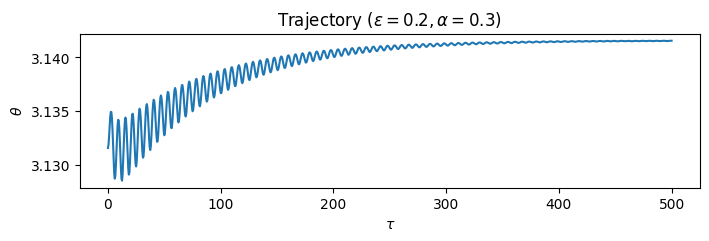

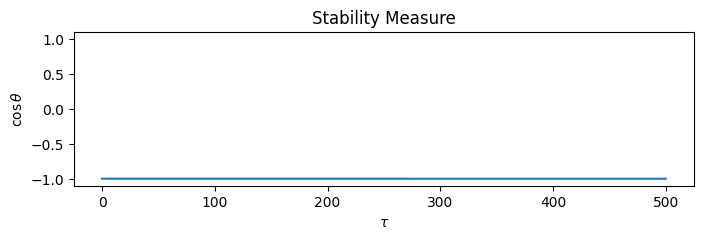

In [15]:
# SOLUTION of EOM & plots
# input parameters
epsilon = 0.2
alpha = 0.3
zeta = 0.1

# number of decay times we want to integrate over
n_decay = 100

# define span of tau
tau_min = 0
tau_max = n_decay/(2*zeta)
tau_span = [tau_min, tau_max]

# define an initial state
delta_theta = 0.01 # deviation of theta from pi/inverted state
theta_0 = np.pi - delta_theta
ang_vel_0 = 0
y_0 = [theta_0, ang_vel_0]

# solve equation of motion
solution = solve_ivp(pivot_driven_pendulum,
                     tau_span, y_0,
                     args=(epsilon, alpha, zeta),
                     method='Radau',
                     dense_output=True)

# generate data for plotting
tau_plot = np.linspace(tau_min, tau_max, 1000)
theta_plot = solution.sol(tau_plot)[0]

# --- PLOTTING ---

# Plot 1: Angle theta
plt.figure(figsize=(8, 2))
plt.plot(tau_plot, theta_plot)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\theta$')
plt.title(rf'Trajectory ($\epsilon={epsilon}, \alpha={alpha}$)')
plt.show()

# Plot 2: Stability Measure (cos theta)
plt.figure(figsize=(8, 2))
plt.plot(tau_plot, np.cos(theta_plot))
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\cos \theta$')
plt.ylim(-1.1, 1.1)
plt.title('Stability Measure')
plt.show()